# Can we predict math grades using student's characteristics? 

## Introduction


The data set we have decided to use is the Student Performance data set, for the subject of mathematics. This data set came from two secondary schools in Portugal in 2014 using school reports. The data reflects the performance of students in Mathematics. We hope to answer the question “what attributes/characteristics would affect  final (G3) math grades in Portuguese Secondary Schools?”. Additionally, we hope to predict a student's grade by using a K nearest regression model and a classification model.

## Methods

### Method 1: Regression Model

#### Reading the data

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)
student <- read_csv2("https://raw.githubusercontent.com/kx-chen/dsci-contract/master/student-mat.csv")
student

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


#### Cleaning the Data

In [2]:
student_clean <- student %>% select(school, sex, age, paid, schoolsup, internet, studytime, failures, health, absences, G3)
student_clean

school,sex,age,paid,schoolsup,internet,studytime,failures,health,absences,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,no,yes,no,2,0,3,6,6
GP,F,17,no,no,yes,2,0,3,4,6
GP,F,15,yes,yes,yes,2,3,3,10,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,no,no,no,1,3,3,3,7
MS,M,18,no,no,yes,1,0,5,0,10
MS,M,19,no,no,yes,1,0,5,5,9


#### Visualizations Relevant to Exploratory Data Analysis

To explore the data related to the planned analysis, we decided to take a look at the distribution of different characteristics (Studytime, health, absences, and failures) using bar graphs. This format allows us to **count** the number of students who share that attribute, and this count can be used to visualize a distribution.    

[1] "The graph below describes the distribution of the number of students that study a certain amount of time. For additional context, a studytime value of 1 represents less than 2 hours of studying, a studytime value of 2 represents 2 to 5 hours, a studytime value of 3 represents 5 to 10 hours, and a studytime value of 4 represents more than 10 hours of study time."

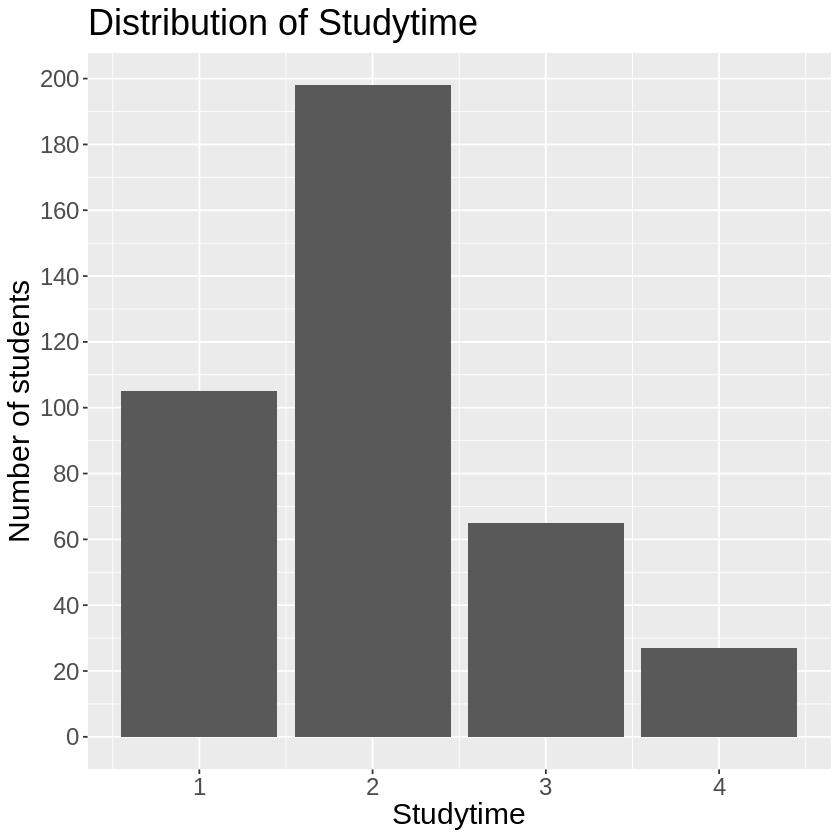

In [3]:
studytime_dist <- ggplot(student , aes(x=studytime)) + geom_bar() + labs(x= "Studytime" , y="Number of students" , title="Distribution of Studytime") + 
theme(text=element_text(size=18)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

"The graph below describes the distribution of the number of students that study a certain amount of time. For additional context, a studytime value of 1 represents less than 2 hours of studying, a studytime value of 2 represents 2 to 5 hours, a studytime value of 3 represents 5 to 10 hours, and a studytime value of 4 represents more than 10 hours of study time." 

studytime_dist

[1] "The graph below describes the distribution of the number of students and their health. For additional context, a health value of 1 is very bad, and a health value of 5 is very good."

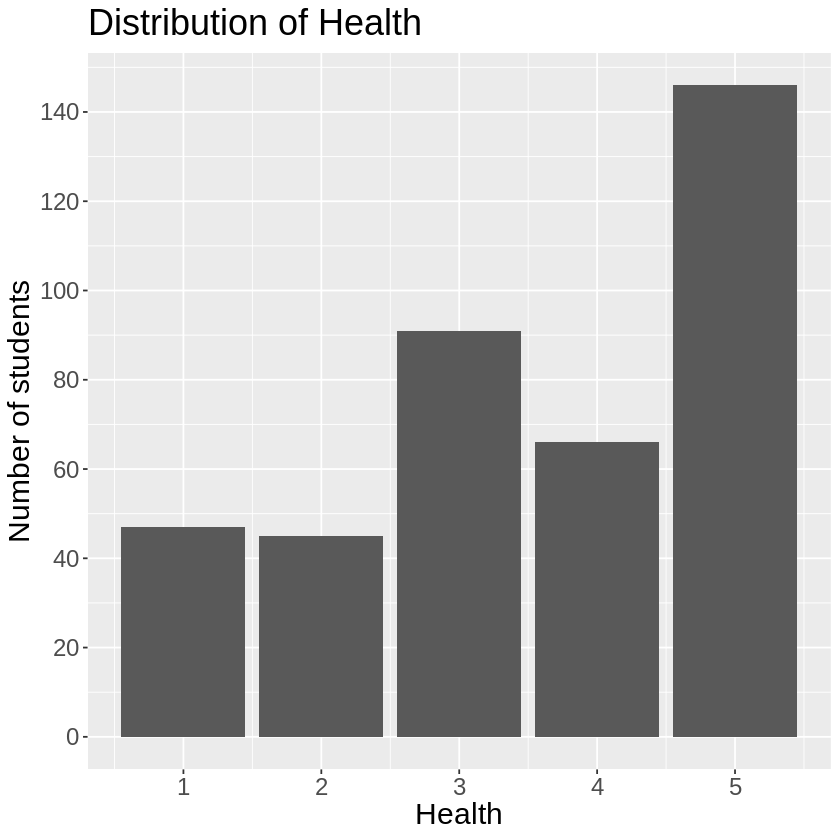

In [4]:
health_dist <- ggplot(student , aes(x=health)) + geom_bar() + labs(x= "Health" , y="Number of students" , title="Distribution of Health") + 
theme(text=element_text(size=18)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

"The graph below describes the distribution of the number of students and their health. For additional context, a health value of 1 is very bad, and a health value of 5 is very good." 

health_dist

[1] "The graph below describes the distribution of the number of students and the number of absences they have, ranging from 0 to 93."

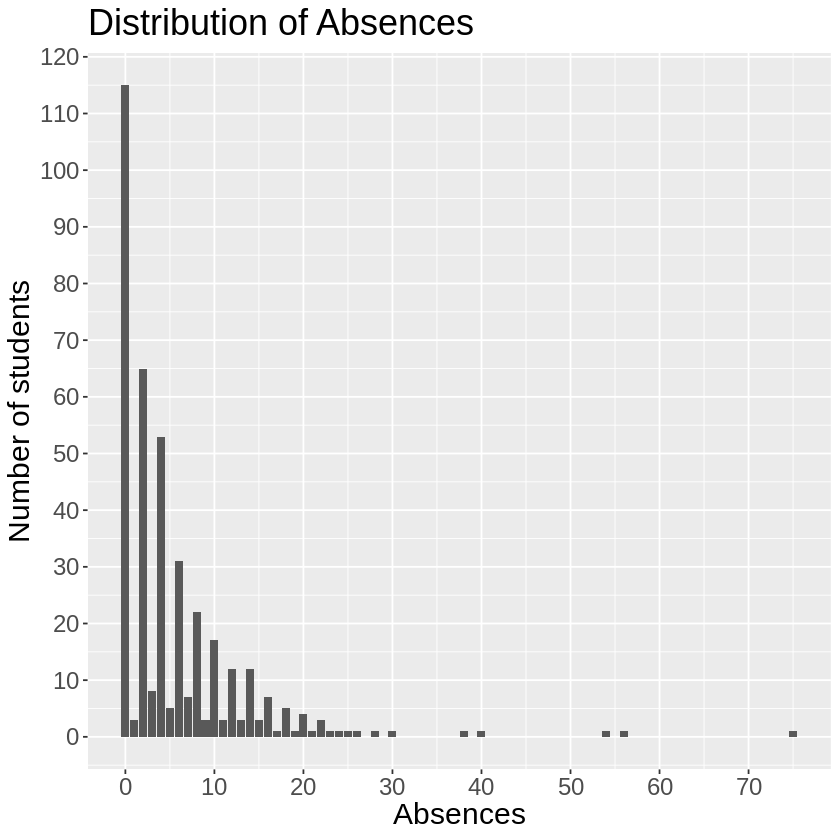

In [5]:
absences_dist <- ggplot(student , aes(x=absences)) + geom_bar() + labs(x= "Absences" , y="Number of students" , title="Distribution of Absences") + 
theme(text=element_text(size=18)) + scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

"The graph below describes the distribution of the number of students and the number of absences they have, ranging from 0 to 93."

absences_dist

[1] "The graph below shows the distribution of the number of students and the number of past class failures, ranging from 0 to 3."

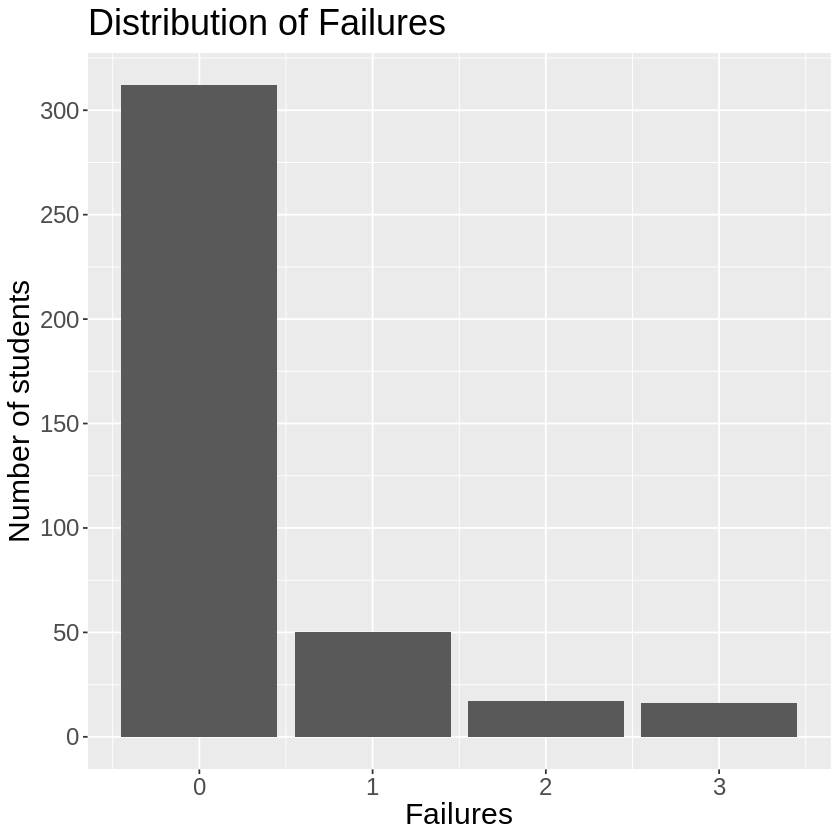

In [6]:
failures_dist <- ggplot(student , aes(x=failures)) + geom_bar() + labs(x= "Failures" , y="Number of students" , title="Distribution of Failures") + 
theme(text=element_text(size=18)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

"The graph below shows the distribution of the number of students and the number of past class failures, ranging from 0 to 3."

failures_dist

#### Setting up

In [7]:
student_split <- initial_split(student_clean, props = 0.80, strata = G3)
student_train <- training(student_split)
student_test <- testing(student_split)

student_split
student_train
student_test

<Analysis/Assess/Total>
<298/97/395>

school,sex,age,paid,schoolsup,internet,studytime,failures,health,absences,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,no,yes,no,2,0,3,6,6
GP,F,17,no,no,yes,2,0,3,4,6
GP,F,15,yes,yes,yes,2,3,3,10,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,no,no,no,1,3,3,3,7
MS,M,18,no,no,yes,1,0,5,0,10
MS,M,19,no,no,yes,1,0,5,5,9


school,sex,age,paid,schoolsup,internet,studytime,failures,health,absences,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,15,yes,no,yes,3,0,5,2,15
GP,F,16,yes,no,no,2,0,5,4,10
GP,F,15,yes,no,yes,2,0,2,0,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,F,18,yes,no,yes,1,0,5,7,6
MS,F,18,no,no,no,2,1,5,0,0
MS,M,20,yes,no,no,2,2,4,11,9


#### Setting up recipe and model

In [8]:
student_recipe <- recipe(G3 ~ age + absences + failures, data = student_train) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% set_engine("kknn") %>% set_mode("regression")

student_recipe
student_spec

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


#### Tuning/Finding ideal K

In [9]:
gridvals <- tibble(neighbors = seq(1, 200))
student_vfold <- vfold_cv(student_train, v = 5, strata = G3)

student_k <- workflow() %>% add_recipe(student_recipe) %>% add_model(student_spec) %>%
             tune_grid(student_vfold, grid = gridvals) %>% collect_metrics() %>% filter(.metric == "rmse") %>% filter(mean == min(mean)) %>% pull(neighbors)

student_k

[1] 17

#### Evaluating on the test set

In [10]:
student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = student_k) %>%
  set_engine("kknn") %>%
  set_mode("regression")

student_fit <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(student_spec) %>%
  fit(data = student_train)

predictions <- student_fit %>%
  predict(student_test) %>%
  bind_cols(student_test)

student_metrics <- metrics(predictions, truth = G3, estimate = .pred)
student_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.0848691
rsq,standard,0.2179942
mae,standard,3.2171013


### Method 2: Classification Model

In an attempt to get the best results possible, we decided to also create a K-NN classification model for our grades as well. 

#### Preparing data for classification

In [11]:
set.seed(6969)
b <- c(-Inf, 5, 10, Inf)

names <- c("Low", "Medium", "High")

# Categorize students by the labels above
student_clean$G3category <- cut(student_clean$G3, breaks = b, labels = names)

student_clean

student_split <- initial_split(student_clean, props = 0.80, strata = G3category)
student_train <- training(student_split)
student_test <- testing(student_split)

school,sex,age,paid,schoolsup,internet,studytime,failures,health,absences,G3,G3category
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,no,yes,no,2,0,3,6,6,Medium
GP,F,17,no,no,yes,2,0,3,4,6,Medium
GP,F,15,yes,yes,yes,2,3,3,10,10,Medium
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,no,no,no,1,3,3,3,7,Medium
MS,M,18,no,no,yes,1,0,5,0,10,Medium
MS,M,19,no,no,yes,1,0,5,5,9,Medium


#### Setup recipe and models for tuning

In [12]:
# Setup cross validation
student_vfold <- vfold_cv(student_clean, v = 20, strata = G3category)

# Setup recipe
student_recipe <- recipe(G3category ~ age + absences + failures, data = student_train) %>%
                    step_scale(all_predictors()) %>% step_center(all_predictors())

# Setup classification model
student_classification_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% set_engine("kknn") %>% set_mode("classification")

#### Finding the ideal K value

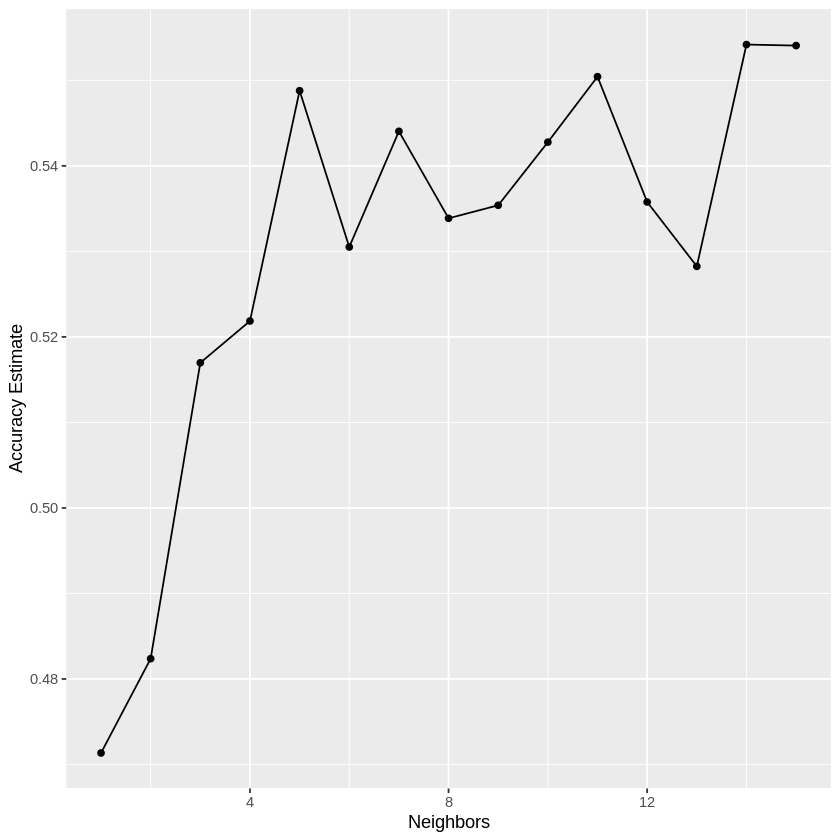

In [13]:
# Try 20 values of K, find best one
student_classification_results <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(student_classification_spec) %>%
  tune_grid(resamples = student_vfold, grid = 20) %>%
  collect_metrics()

# Filter for accuracy
accuracies <- student_classification_results %>%
  filter(.metric == "accuracy")

# Graph the accuracy vs. K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

#### Finding the accuracy 

From the graph above, we can see that a K value of 14 yields the best results.

In [17]:
student_classification_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>% set_engine("kknn") %>% set_mode("classification")

student_fit <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(student_classification_spec) %>%
  fit(data = student_train)
student_fit


student_predictions <- predict(student_fit, student_test) %>%
  bind_cols(student_test) %>% metrics(truth = G3category, estimate = .pred_class)
student_predictions


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~14, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4747475
Best kernel: rectangular
Best k: 14

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5714286
kap,multiclass,0.2017067


## Results

### Final Visualization Model of the Analysis

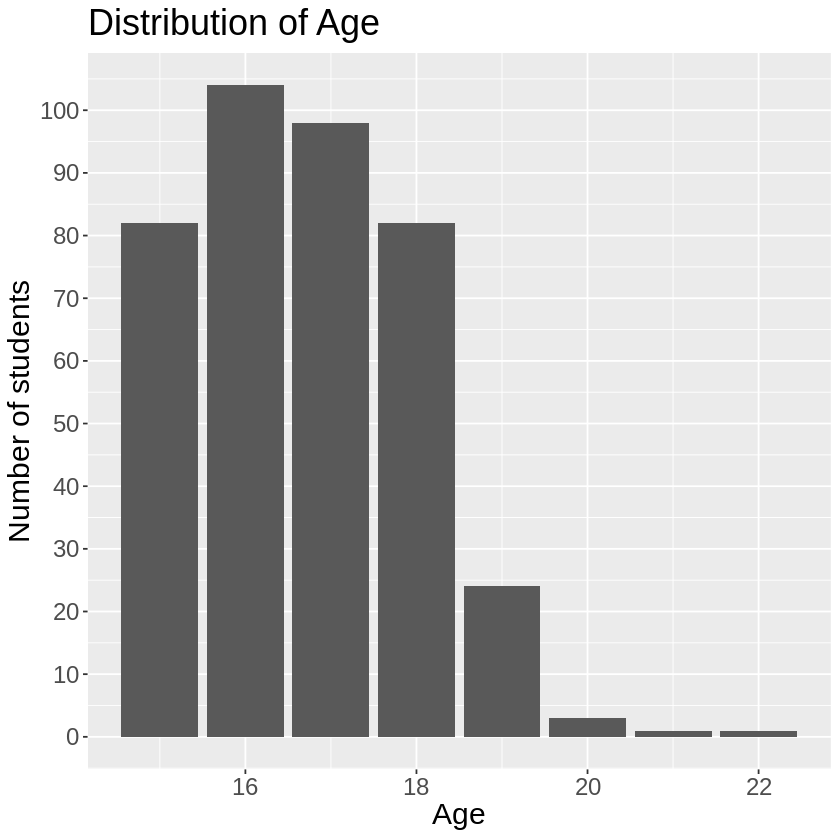

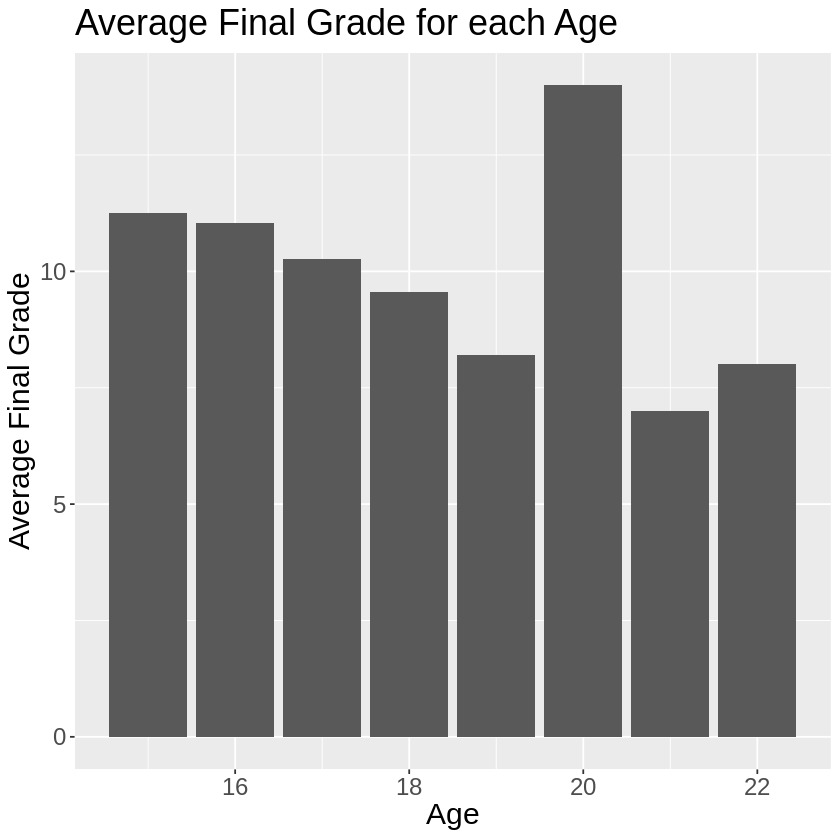

In [18]:
student_preds <- student_fit %>% predict(student_train) %>% bind_cols(student_train)

# plot_final <- ggplot(student_preds , aes(x = health , y = G3)) + geom_bar(stat="identity") + labs(x="Health of Student" , y="Final Grade") 
# + 
# geom_line(data=student_preds, aes(x=health,y=.pred), color="blue")

age_15 <- student_clean %>% filter(age==15)
age_15_G3 <- summarize(age_15 , avgG3_15 = sum(G3) / (age_15 %>% nrow()))
age_16 <- student_clean %>% filter(age==16) 
age_16_G3 <- summarize(age_16 , avgG3_16=sum(G3) / (age_16 %>% nrow()))
age_17 <- student_clean %>% filter(age==17) 
age_17_G3 <- summarize(age_17 , avgG3_17=sum(G3) / (age_17 %>% nrow())) 
age_18 <- student_clean %>% filter(age==18) 
age_18_G3 <- summarize(age_18 , avgG3_18=sum(G3) / (age_18 %>% nrow())) 
age_19 <- student_clean %>% filter(age==19) 
age_19_G3 <- summarize(age_19 , avgG3_19=sum(G3) / (age_19 %>% nrow())) 
age_20 <- student_clean %>% filter(age==20) 
age_20_G3 <- summarize(age_20 , avgG3_20=sum(G3) / (age_20 %>% nrow())) 
age_21 <- student_clean %>% filter(age==21) 
age_21_G3 <- summarize(age_21 , avgG3_21=sum(G3) / (age_21 %>% nrow())) 
age_22 <- student_clean %>% filter(age==22) 
age_22_G3 <- summarize(age_22 , avgG3_22=sum(G3) / (age_22 %>% nrow())) 

age_avgG3 <- tibble(Age = 15:22 , Avg_final_grade = c(age_15_G3,age_16_G3,age_17_G3,age_18_G3,age_19_G3,age_20_G3,age_21_G3,age_22_G3) )

age_dist <- ggplot(student , aes(x=age)) + geom_bar() + labs(x= "Age" , y="Number of students" , title="Distribution of Age") + 
theme(text=element_text(size=18)) + scale_y_continuous(breaks = scales::pretty_breaks(n = 10))

age_dist


# plot_final


plot <- ggplot(age_avgG3 , aes(x=Age , y=Avg_final_grade)) + geom_bar(stat="identity") + labs(x="Age" , y="Average Final Grade" , title="Average Final Grade for each Age") +
theme(text=element_text(size=18))
plot 

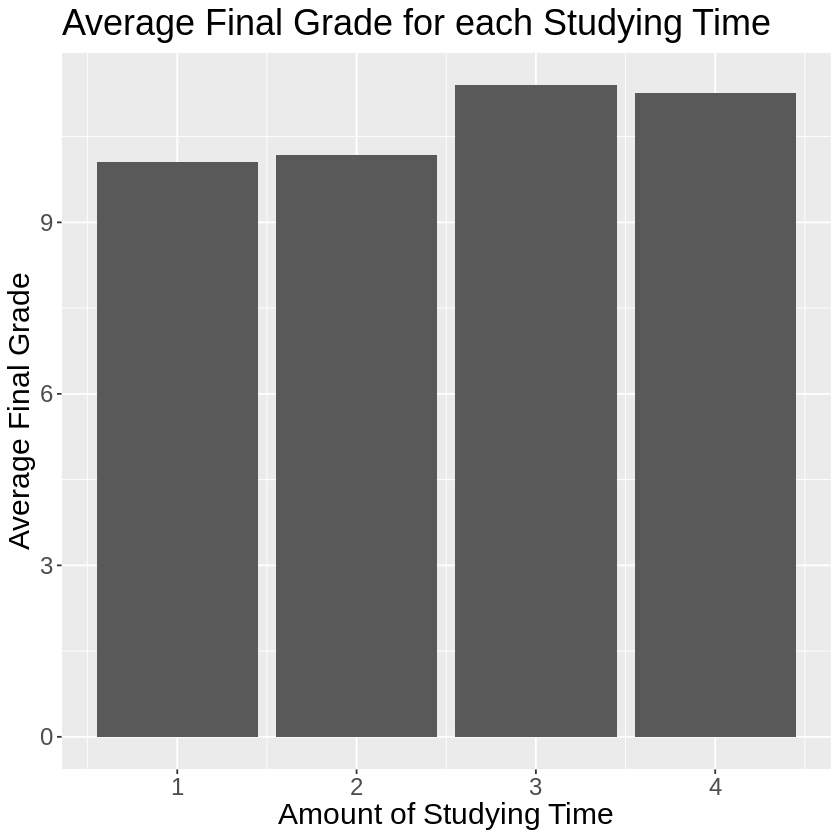

In [19]:
time1 <- student_clean %>% filter(studytime == 1) 
time1_avgG3 <- summarize(time1 , avgG3_time1 = sum(G3) / (time1 %>% nrow()))
time2 <- student_clean %>% filter(studytime == 2) 
time2_avgG3 <- summarize(time2 , avgG3_time2 = sum(G3) / (time2 %>% nrow()))
time3 <- student_clean %>% filter(studytime == 3) 
time3_avgG3 <- summarize(time3 , avgG3_time3 = sum(G3) / (time3 %>% nrow()))
time4 <- student_clean %>% filter(studytime == 4) 
time4_avgG3 <- summarize(time4 , avgG3_time4 = sum(G3) / (time4 %>% nrow()))

studytime_avgG3 <- tibble(time = 1:4 , Avg_final_grade = c(time1_avgG3,time2_avgG3,time3_avgG3,time4_avgG3) )

studytime_plot <- ggplot(studytime_avgG3 , aes(x=time , y=Avg_final_grade)) + geom_bar(stat="identity") + labs(x="Amount of Studying Time" , y="Average Final Grade" ,title="Average Final Grade for each Studying Time") +
theme(text=element_text(size=18))

studytime_plot

Paid,Avg_final_grade
<chr>,<named list>
Yes,10.92265
No,9.985981


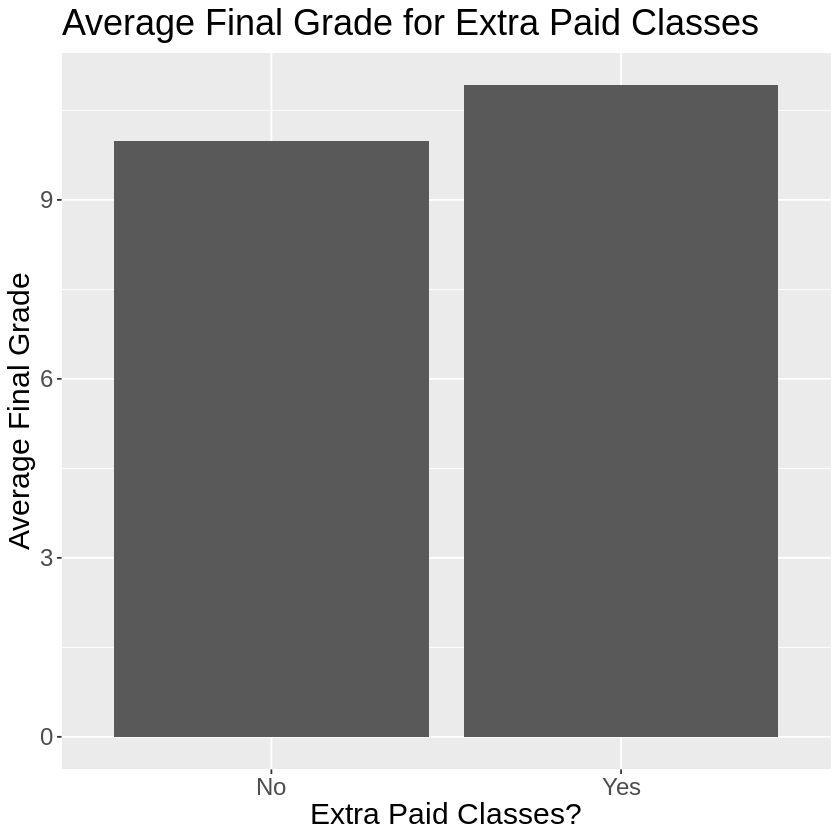

In [27]:
paid <- student_clean %>% filter(paid == "yes") 
paid_avgG3 <- summarize(paid , avgG3_paid = sum(G3)) / (paid %>% nrow())

no_paid <- student_clean %>% filter(paid == "no")
no_paid_avgG3 <- summarize(no_paid , avgG3_no_paid = sum(G3)) / (no_paid %>% nrow())

paid_avgG3 <- tibble(Paid = c("Yes" , "No"), Avg_final_grade = c(paid_avgG3, no_paid_avgG3))
paid_avgG3

paid_plot <- ggplot(paid_avgG3 , aes(x=Paid , y=Avg_final_grade)) + geom_bar(stat="identity") + labs(x="Extra Paid Classes?" , y="Average Final Grade" ,title="Average Final Grade for Extra Paid Classes") +
theme(text=element_text(size=18))

paid_plot

## Discussion

## References

Altabrawee, H., Ali, O. & Qaisar, S. (2019). Predicting students’ performance using machine learning techniques. Journal of University of Babylon for pure and applied sciences, 27(1), 194-205. http://doi:10.29196/jubpas.v27i1.2108. 

Cortez, P., & Silva, A. M. G. (2008). Using data mining to predict secondary school student performance (FUBUTEC 2008) [Data set].  In A. Brito, & J. Teixeira (Eds.), Proceedings of 5th Annual Future Business Technology Conference, Porto, 5-12. http://www3.dsi.uminho.pt/pcortez/student.pdf.